<a href="https://colab.research.google.com/github/kdemertzis/Hydroinformatics/blob/main/05_Evapuration_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors 
from matplotlib.ticker import PercentFormatter 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l1
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense ,Dropout
from tensorflow.keras import layers

import datetime
import math

In [5]:
df = pd.read_excel('https://github.com/kdemertzis/Hydroinformatics/blob/main/data/MaruteruOriginalDatainCM.xlsx?raw=true')

In [6]:
df.head()

,Year,SMW,MaxT,MinT,RH1,RH2,RF,WS,SSH,EVPcm
0,1994,1,27.2,18.6,90.0,69.0,1.5,2.6,6.8,1.91
1,1994,2,27.3,19.1,91.0,69.0,0.2,2.6,6.4,1.99
2,1994,3,27.9,19.3,92.0,68.0,0.1,1.9,7.2,1.84
3,1994,4,28.0,19.3,92.0,70.0,0.0,2.0,6.7,1.71
4,1994,5,28.7,19.3,93.0,68.0,0.9,1.8,7.2,2.00


In [7]:
df.head()

,Year,SMW,MaxT,MinT,RH1,RH2,RF,WS,SSH,EVPcm
0,1994,1,27.2,18.6,90.0,69.0,1.5,2.6,6.8,1.91
1,1994,2,27.3,19.1,91.0,69.0,0.2,2.6,6.4,1.99
2,1994,3,27.9,19.3,92.0,68.0,0.1,1.9,7.2,1.84
3,1994,4,28.0,19.3,92.0,70.0,0.0,2.0,6.7,1.71
4,1994,5,28.7,19.3,93.0,68.0,0.9,1.8,7.2,2.00


In [8]:
df = df.rename(columns={"Year": "year", 'MaxT':'MAX','MinT':'MIN', 'RH1': 'RHI', 'RH2':'RHII', 'EVPcm':'EVAP'})

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    884 non-null    int64  
 1   SMW     884 non-null    int64  
 2   MAX     884 non-null    float64
 3   MIN     884 non-null    float64
 4   RHI     884 non-null    float64
 5   RHII    884 non-null    float64
 6   RF      884 non-null    float64
 7   WS      884 non-null    float64
 8   SSH     884 non-null    float64
 9   EVAP    884 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 69.2 KB


In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,884.0,2002.000000,4.901753,1994.00,1998.000,2002.00,2006.000,2010.0
SMW,884.0,26.500000,15.016827,1.00,13.750,26.50,39.250,52.0
MAX,884.0,30.880430,2.896401,23.70,28.900,30.60,32.325,42.7
MIN,884.0,22.518100,2.903825,15.00,20.275,23.00,24.700,30.2
RHI,884.0,88.998529,4.756143,9.30,87.100,89.60,91.700,97.7
RHII,884.0,67.209615,10.973660,27.70,60.850,67.30,74.450,95.1
RF,884.0,17.618439,36.940888,0.00,0.000,0.00,17.775,332.0
WS,884.0,3.904525,2.417673,1.20,2.100,3.00,5.100,13.2
SSH,884.0,6.031674,2.347045,0.00,4.300,6.40,7.900,13.9
EVAP,884.0,3.359276,1.175747,1.67,2.500,3.07,4.000,8.6


In [11]:
df.isnull().sum()

year    0
SMW     0
MAX     0
MIN     0
RHI     0
RHII    0
RF      0
WS      0
SSH     0
EVAP    0
dtype: int64

In [12]:
sns.set_theme(style="ticks", color_codes=True)

In [13]:
#Drop Emp_Title as it is not required
df = df.drop(["SSH","SMW"], axis=1)

In [14]:
gby_df = df.groupby(['year'],as_index=False).mean()

In [15]:
gby_df

,year,MAX,MIN,RHI,RHII,RF,WS,EVAP
0,1994,30.828846,22.600000,88.942308,67.211538,26.663462,3.005769,2.611346
1,1995,31.325000,21.636538,88.492308,67.211538,28.750000,3.005769,2.614231
2,1996,30.951923,21.726923,89.563462,67.211538,33.653846,3.005769,2.614231
3,1997,31.051923,21.540385,89.978846,67.211538,22.463462,3.005769,2.614231
4,1998,31.515385,22.438462,89.700000,77.194231,0.000000,4.901923,2.655577
5,1999,31.019231,21.794231,89.467308,69.096154,0.000000,4.901923,3.509615
6,2000,30.915385,21.775000,88.505769,69.817308,0.000000,4.913462,3.728846
7,2001,31.244231,21.969231,87.721154,66.911538,0.000000,5.001923,3.573077
8,2002,31.507692,22.019231,87.730769,64.171154,9.107692,5.136538,3.842308
9,2003,30.501923,22.800000,90.361538,72.865385,18.280769,5.221154,3.540385


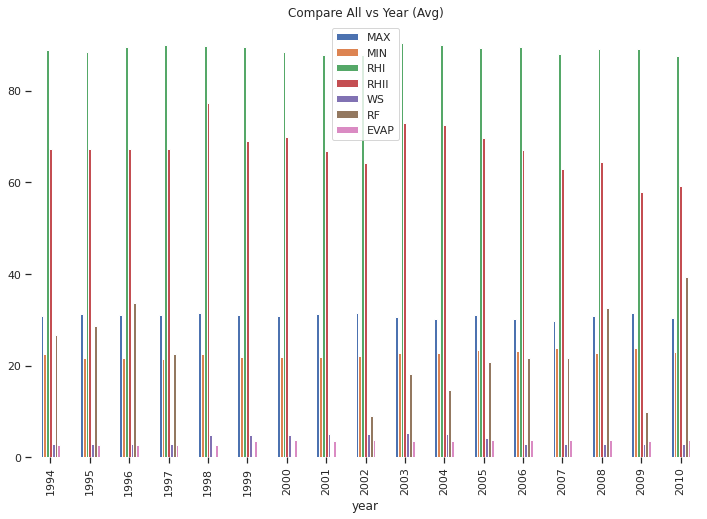

In [16]:
gby_df.plot(x="year", y=['MAX', 'MIN', 'RHI', 'RHII', 'WS', 'RF',
       'EVAP'], kind="bar", title="Compare All vs Year (Avg)", figsize=(12,8))
plt.box(False)

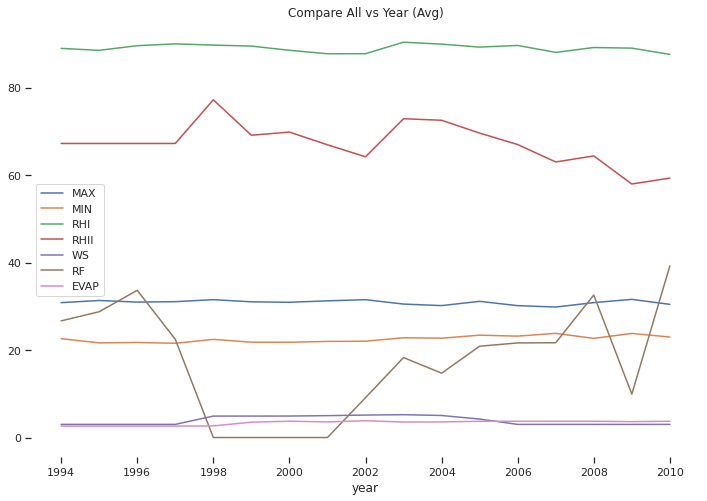

In [17]:
gby_df.plot(x="year", y=['MAX', 'MIN', 'RHI', 'RHII', 'WS', 'RF',
       'EVAP'], kind="line", title="Compare All vs Year (Avg)", figsize=(12,8))
plt.box(False)

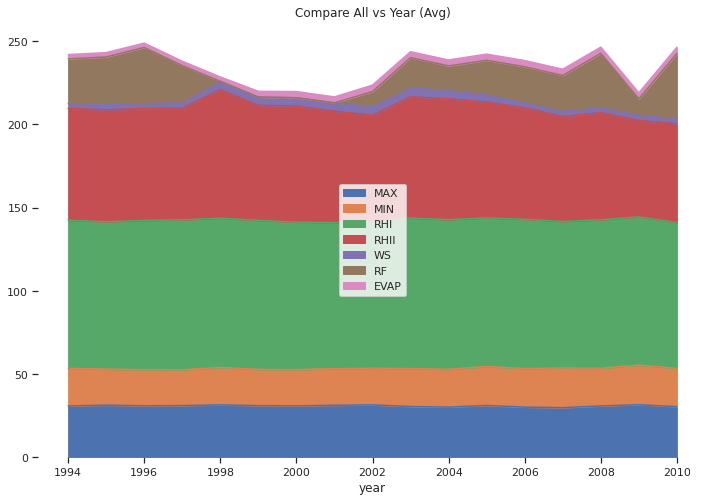

In [18]:
gby_df.plot(x="year", y=['MAX', 'MIN', 'RHI', 'RHII', 'WS', 'RF',
       'EVAP'], kind="area", title="Compare All vs Year (Avg)", figsize=(12,8))
plt.box(False)

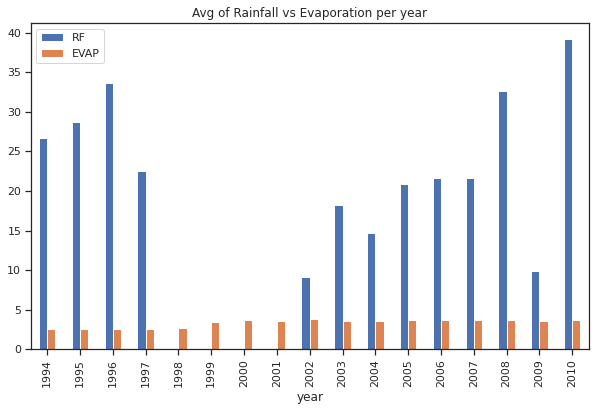

In [19]:
gby_df.plot(x="year", y=["RF", "EVAP"], kind="bar", title="Avg of Rainfall vs Evaporation per year", figsize=(10,6))
plt.box(True)

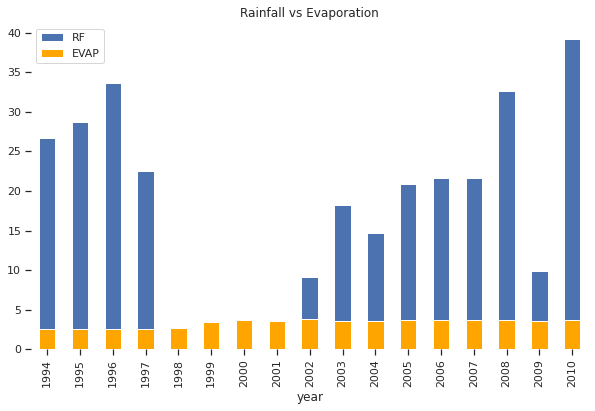

In [20]:
ax = gby_df.plot(x="year", y=["RF"], kind="bar")
gby_df.plot(ax=ax, x="year", y=["EVAP"], kind="bar", color="orange", title="Rainfall vs Evaporation", figsize=(10,6))
plt.box(False)

Text(0.5, 0.98, 'Rainfall vs Year')

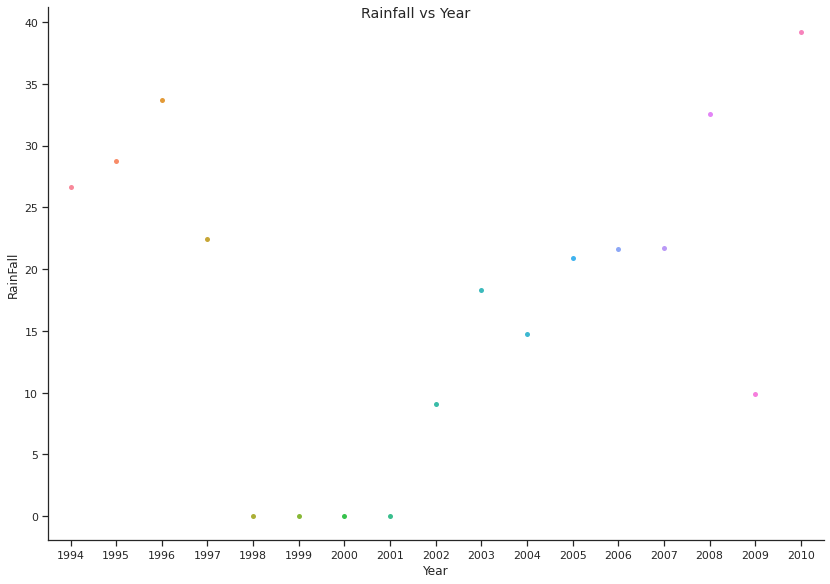

In [21]:
s = sns.catplot(x="year", y="RF", kind="swarm", data=gby_df, height=8.27, aspect=11.7/8.27)
s.set_xlabels("Year")
s.set_ylabels("RainFall")
s.fig.suptitle('Rainfall vs Year')

Text(0.5, 0.98, 'Rainfall vs Year')

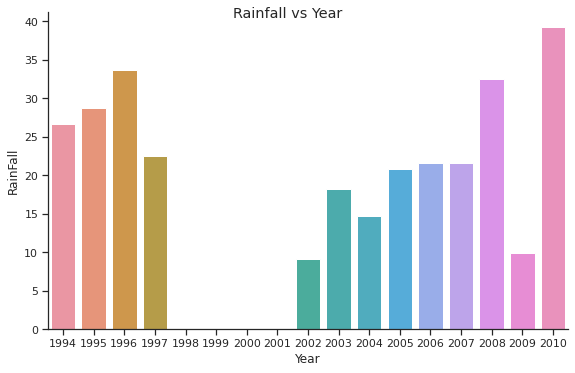

In [22]:
s = sns.catplot(x="year", y="RF", kind="bar", data=gby_df, height=5.27, aspect=9.7/6.27)
s.set_xlabels("Year")
s.set_ylabels("RainFall")
s.fig.suptitle('Rainfall vs Year')

In [23]:
#Drop year as it is not required
df = df.drop(["year"], axis=1)

In [24]:
df.head()

,MAX,MIN,RHI,RHII,RF,WS,EVAP
0,27.2,18.6,90.0,69.0,1.5,2.6,1.91
1,27.3,19.1,91.0,69.0,0.2,2.6,1.99
2,27.9,19.3,92.0,68.0,0.1,1.9,1.84
3,28.0,19.3,92.0,70.0,0.0,2.0,1.71
4,28.7,19.3,93.0,68.0,0.9,1.8,2.00


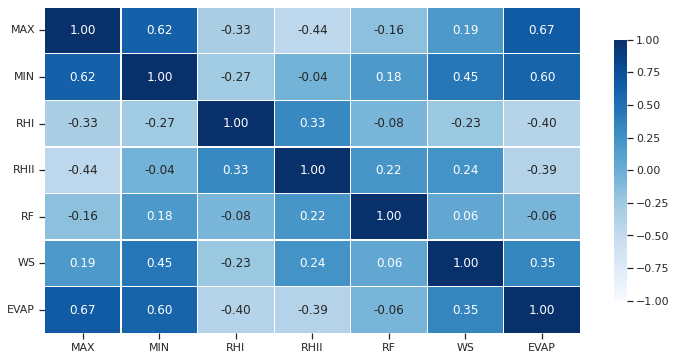

In [25]:
# correlation heat map
plt.figure(figsize=(12, 6))
df_corr = df.corr()

# min -1 and max +1 as we are plotting correlation
sns.heatmap(df.corr(), cmap="Blues", annot=True, fmt=".2f", vmin= -1.0, vmax=1.0,
           linewidth=0.3, cbar_kws={"shrink": .8})
# yticks
plt.yticks(rotation=0)
plt.show()

In [26]:
df = df.drop("RHII", axis=1)
df.columns

Index(['MAX', 'MIN', 'RHI', 'RF', 'WS', 'EVAP'], dtype='object')

In [27]:
from scipy import stats
df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

,MAX,MIN,RHI,RF,WS,EVAP
0,27.2,18.6,90.0,1.5,2.6,1.91
1,27.3,19.1,91.0,0.2,2.6,1.99
2,27.9,19.3,92.0,0.1,1.9,1.84
3,28.0,19.3,92.0,0.0,2.0,1.71
4,28.7,19.3,93.0,0.9,1.8,2.00
...,...,...,...,...,...,...
879,30.3,20.3,88.6,0.0,4.2,2.80
880,26.1,20.1,89.0,107.0,3.0,2.80
881,27.3,20.1,88.1,0.0,2.9,2.60
882,27.3,16.2,83.1,0.0,2.1,2.50


In [28]:
X = df.drop('EVAP', axis=1).values
y = df['EVAP'].values

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [30]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
X_train.shape

(707, 5)

In [32]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [33]:
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, Input
from tensorflow.keras import Model

In [34]:
def build_model():
    # Define model layers.
    input_layer = Input(shape=(5,))
    first_dense = Dense(units='128', activation='relu')(input_layer)
    # Y1 output will be fed from the first dense
    y1_output = Dense(units='1', name='layer1_output')(first_dense)
    second_dense = Dense(units='128',activation='relu')(first_dense)
    # Y2 output will be fed from the second dense
    y2_output = Dense(units='1',name='layer2_output')(second_dense)
    # Define the model with the input layer 
    # and a list of output layers
    model = Model(inputs=input_layer,outputs=[y1_output, y2_output])
    return model

In [35]:
model = build_model()
model.compile(loss="mean_squared_error", optimizer='adam')

In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          768         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['dense[0][0]']                  
                                                                                                  
 layer1_output (Dense)          (None, 1)            129         ['dense[0][0]']                  
                                                                                              

In [37]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=100, batch_size=5, callbacks=[early_stop])

Epoch 1/100
142/142 [==============================] - 1s 4ms/step - loss: 7.1089 - layer1_output_loss: 4.8058 - layer2_output_loss: 2.3031 - val_loss: 1.7445 - val_layer1_output_loss: 0.9156 - val_layer2_output_loss: 0.8290
Epoch 2/100
142/142 [==============================] - 0s 2ms/step - loss: 1.7122 - layer1_output_loss: 0.9021 - layer2_output_loss: 0.8101 - val_loss: 1.5231 - val_layer1_output_loss: 0.8165 - val_layer2_output_loss: 0.7065
Epoch 3/100
142/142 [==============================] - 0s 3ms/step - loss: 1.5867 - layer1_output_loss: 0.8378 - layer2_output_loss: 0.7489 - val_loss: 1.4364 - val_layer1_output_loss: 0.7802 - val_layer2_output_loss: 0.6561
Epoch 4/100
142/142 [==============================] - 0s 2ms/step - loss: 1.4956 - layer1_output_loss: 0.7943 - layer2_output_loss: 0.7012 - val_loss: 1.3708 - val_layer1_output_loss: 0.7249 - val_layer2_output_loss: 0.6459
Epoch 5/100
142/142 [==============================] - 0s 2ms/step - loss: 1.4298 - layer1_output_lo

In [38]:
losses = pd.DataFrame(model.history.history)

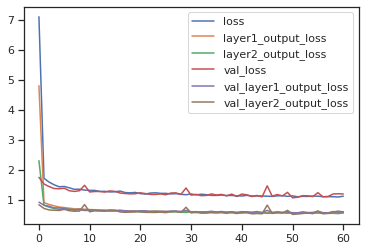

In [39]:
losses.plot()

In [40]:
test_predictions = model.predict(X_test)

In [41]:
test_predictions

[array([[2.4115295],
        [2.54674  ],
        [6.080369 ],
        [2.4879615],
        [4.6853185],
        [3.3250668],
        [3.9465687],
        [2.3962126],
        [3.7589517],
        [5.666752 ],
        [2.809093 ],
        [2.379494 ],
        [2.425483 ],
        [3.7251036],
        [2.5707207],
        [2.4314313],
        [4.2765937],
        [2.5445132],
        [2.9431973],
        [2.724552 ],
        [3.016126 ],
        [3.0452633],
        [3.5909286],
        [2.8156414],
        [2.6559083],
        [5.4752727],
        [4.41201  ],
        [2.9542456],
        [3.2407055],
        [2.3666646],
        [3.8854   ],
        [3.0584216],
        [2.4100296],
        [5.7320952],
        [4.8083673],
        [2.4621496],
        [2.809566 ],
        [3.1981654],
        [2.3942003],
        [2.7173395],
        [5.1891847],
        [3.048401 ],
        [2.6170063],
        [2.6877725],
        [2.361196 ],
        [2.365592 ],
        [2.389268 ],
        [2.42

In [42]:
pred_df = pd.DataFrame(y_test,columns=['Test Y'])

In [43]:
pred_df

,Test Y
0,2.60
1,1.97
2,6.70
3,2.11
4,4.23
...,...
172,2.80
173,3.50
174,1.99
175,4.00


In [44]:
test_predictions = pd.Series(test_predictions[0].reshape(177,))

In [45]:
pred_df = pd.concat([pred_df,test_predictions],axis=1)

In [46]:
pred_df.columns = ['Test Y','Model Predictions']

In [47]:
pred_df

,Test Y,Model Predictions
0,2.60,2.411530
1,1.97,2.546740
2,6.70,6.080369
3,2.11,2.487962
4,4.23,4.685318
...,...,...
172,2.80,2.436808
173,3.50,2.643549
174,1.99,2.452702
175,4.00,3.043727


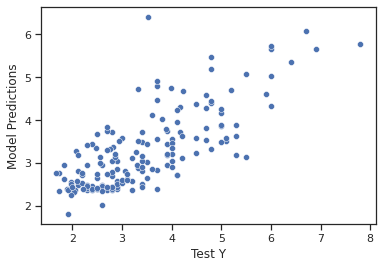

In [48]:
sns.scatterplot(x='Test Y',y='Model Predictions',data=pred_df)

In [49]:
pred_df['Error'] = pred_df['Test Y'] - pred_df['Model Predictions']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


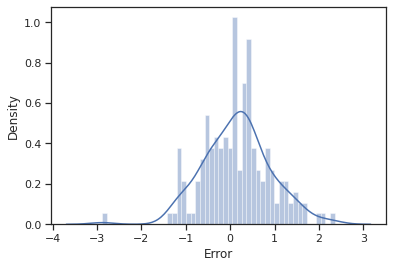

In [50]:
sns.distplot(pred_df['Error'],bins=50)

# Mean Absolute Error

In [51]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
mean_absolute_error(pred_df['Test Y'],pred_df['Model Predictions'])

0.6015757631582056

# Mean Squared Error

In [52]:
mean_squared_error(pred_df['Test Y'],pred_df['Model Predictions'])

0.5982021082091223

# Predicting on brand new data

In [53]:
new_data = [[29.2,12.2,67.6,5.7,6.0]]

In [54]:
# Don't forget to scale!
scaler.transform(new_data)

array([[ 0.28947368, -0.18421053,  0.65950226,  0.01716867,  0.4       ]])

In [55]:
new_data = scaler.transform(new_data)

In [56]:
model.predict(new_data)

[array([[2.624919]], dtype=float32), array([[2.6729567]], dtype=float32)]